In [231]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pickle

RANDOM_STATE = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [232]:
benign_data = pd.read_csv("benign_data.csv")
benign_data.head()

,flow_name,packets_number,total_packets_len,flow_duration,max_packet_len,min_packet_len,mean_packet_len,std_packet_len,flow_IAT_mean,flow_IAT_std,flow_IAT_max,flow_IAT_min,flow_IAT_total,total_headers_len,packets/s,FIN_flag_count,SYN_flag_count,RST_flag_count,PUSH_flag_count,ACK_flag_count
0,flow_1586.pcap,44,12149,2246474.0,1514,54,276.113636,415.598704,5.224358e+04,3.068222e+05,2034566.0,0.0,2246474.0,2376,22.000000,3,2.0,4.0,16.0,40.0
1,flow_3041.pcap,18,8434,18570397.0,583,54,468.555556,214.149538,1.092376e+06,9.119583e+05,2130136.0,2.0,18570397.0,972,1.636364,0,2.0,1.0,14.0,17.0
2,flow_3411.pcap,76,46588,189063668.0,1514,54,613.000000,660.657826,2.520849e+06,1.234982e+07,64999674.0,0.0,189063668.0,4104,19.000000,2,2.0,2.0,21.0,74.0
3,flow_768.pcap,22,5032,64944162.0,1464,54,228.727273,407.013199,3.092579e+06,9.989109e+06,45079363.0,0.0,64944162.0,1188,5.500000,2,2.0,2.0,4.0,19.0
4,flow_292.pcap,28,7769,259705.0,1490,54,277.464286,404.649097,9.618704e+03,2.105712e+04,64654.0,0.0,259705.0,1512,28.000000,2,2.0,2.0,14.0,25.0


In [233]:
pd.DataFrame(benign_data.isna().sum()).T

,flow_name,packets_number,total_packets_len,flow_duration,max_packet_len,min_packet_len,mean_packet_len,std_packet_len,flow_IAT_mean,flow_IAT_std,flow_IAT_max,flow_IAT_min,flow_IAT_total,total_headers_len,packets/s,FIN_flag_count,SYN_flag_count,RST_flag_count,PUSH_flag_count,ACK_flag_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2


In [234]:
benign_data = benign_data.dropna()

In [235]:
benign_data.describe()

,packets_number,total_packets_len,flow_duration,max_packet_len,min_packet_len,mean_packet_len,std_packet_len,flow_IAT_mean,flow_IAT_std,flow_IAT_max,flow_IAT_min,flow_IAT_total,total_headers_len,packets/s,FIN_flag_count,SYN_flag_count,RST_flag_count,PUSH_flag_count,ACK_flag_count
count,3472.000000,3.472000e+03,3.472000e+03,3472.000000,3472.000000,3472.000000,3472.000000,3.472000e+03,3.472000e+03,3.472000e+03,3.472000e+03,3.472000e+03,3.472000e+03,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000
mean,134.914459,9.949424e+04,1.159388e+08,1262.213710,56.864055,396.111930,415.915994,1.666164e+06,5.728392e+06,3.347471e+07,5.866421e+04,1.159388e+08,7.285381e+03,27.712509,1.790899,2.151498,1.534850,37.154378,132.643721
std,888.997027,9.140587e+05,4.197006e+08,420.011971,5.230053,185.228505,157.723918,3.341580e+06,9.620245e+06,6.769943e+07,1.937294e+06,4.197006e+08,4.800584e+04,161.954701,1.230107,0.867199,1.420493,201.252409,888.996595
min,2.000000,1.500000e+02,1.846300e+04,66.000000,54.000000,58.800000,0.000000,1.191323e+02,0.000000e+00,5.482000e+03,0.000000e+00,1.846300e+04,1.080000e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,8.434000e+03,2.180082e+06,1410.000000,54.000000,289.694264,243.961753,5.345920e+04,3.163460e+05,2.054680e+06,0.000000e+00,2.180082e+06,1.026000e+03,5.702381,1.000000,2.000000,0.000000,9.000000,18.000000
50%,29.500000,1.001600e+04,3.007855e+07,1466.000000,54.000000,358.703704,456.091977,1.076790e+06,2.517696e+06,1.503790e+07,0.000000e+00,3.007855e+07,1.593000e+03,13.500000,2.000000,2.000000,1.000000,14.000000,27.000000
75%,45.000000,1.492850e+04,6.016458e+07,1514.000000,54.000000,468.555556,510.465411,1.703030e+06,6.672371e+06,4.500134e+07,1.000000e+00,6.016458e+07,2.430000e+03,19.000000,2.000000,2.000000,2.000000,17.000000,41.000000
max,32952.000000,3.514235e+07,9.082308e+09,1522.000000,78.000000,1216.620681,714.736839,8.063689e+07,2.216706e+08,9.159831e+08,6.601860e+07,9.082308e+09,1.779408e+06,6590.400000,13.000000,20.000000,10.000000,6844.000000,32951.000000


In [236]:
benign_data.shape

(3472, 20)

In [237]:
benign_data = benign_data.drop(columns=['flow_name'])

In [238]:
class AE(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.encoder = []
        self.decoder = []

        for layer in config:
            if type(layer) == str:
                self.encoder += [torch.nn.ReLU()]
                self.decoder.insert(0, torch.nn.ReLU())
            else:
                self.encoder += [torch.nn.Linear(layer[0], layer[1])]
                self.decoder.insert(0, torch.nn.Linear(layer[1], layer[0]))

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [239]:
class FlowDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        return torch.tensor(row, dtype=torch.float32)

In [240]:
scaler = StandardScaler()
benign_data = scaler.fit_transform(benign_data)

In [241]:
benign_data_dataset = FlowDataset(benign_data)
benign_dataloader = DataLoader(benign_data_dataset, batch_size=32, shuffle=True)

In [242]:
def train(model, criterion, optimizer, train_dataloader, model_name, n_epochs=100, plot_loss=True):
    losses = []
    min_loss = float('inf')

    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for feat in train_dataloader:
            feat = feat.to(device)
            reconstructed = model(feat)
            loss = criterion(reconstructed, feat)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.cpu()

        epoch_loss /= (32 * len(train_dataloader))
        epoch_loss = epoch_loss.detach().numpy()
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            torch.save(model.state_dict(), f"models/{model_name}.pickle")
        losses += [epoch_loss]
    if plot_loss:
        plt.plot(losses)

    return float(min_loss)

In [244]:
!mkdir models

100%|██████████| 1000/1000 [06:04<00:00,  2.74it/s]


min loss: 0.0006981781334616244


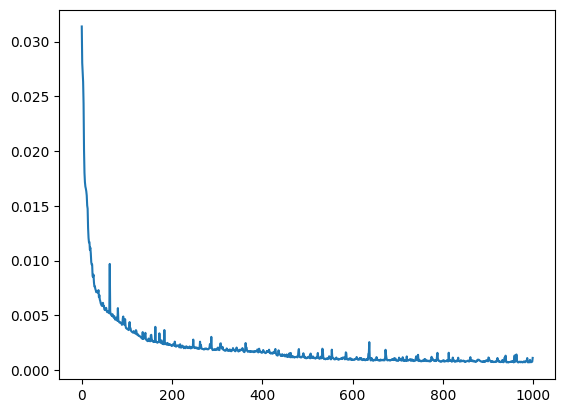

In [245]:
model_config = [[19, 18],'relu',[18, 16],'relu',[16, 12],'relu',[12, 10],'relu',[10, 8]]

model1 = AE(model_config).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)
loss_function = torch.nn.MSELoss()
min_loss = train(model1, loss_function, optimizer, benign_dataloader,
                 "model_1", n_epochs=1_000)
print("\nmin loss: " + str(min_loss))

In [246]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [251]:
training_IRE_list = []

for feat in benign_data:
    feat = torch.Tensor(feat)
    feat = feat.to(device)
    reconstructed = model1(feat)
    loss = loss_function(reconstructed, feat)
    training_IRE_list += [loss.cpu().detach().numpy()]

In [252]:
training_IRE = max(training_IRE_list)
training_IRE

array(2.148479, dtype=float32)

In [253]:
attack_data = pd.read_csv("attack_data.csv")
attack_data.head()

,flow_name,packets_number,total_packets_len,flow_duration,max_packet_len,min_packet_len,mean_packet_len,std_packet_len,flow_IAT_mean,flow_IAT_std,flow_IAT_max,flow_IAT_min,flow_IAT_total,total_headers_len,packets/s,FIN_flag_count,SYN_flag_count,RST_flag_count,PUSH_flag_count,ACK_flag_count
0,flow_85.pcap,35,2663,180227790.0,107,54,76.085714,14.359410,5.300817e+06,1.698966e+07,59983600.0,0.0,180227790.0,1890,8.750000,2,0,3,15,32
1,flow_154.pcap,18,8434,18455678.0,583,54,468.555556,214.149538,1.085628e+06,9.121095e+05,2124754.0,2.0,18455678.0,972,1.636364,0,2,1,14,17
2,flow_103.pcap,1076,820637,212704927.0,1514,54,762.673792,688.654494,1.978650e+05,2.767923e+06,45031286.0,0.0,212704927.0,58104,56.631579,0,2,0,318,1075
3,flow_115.pcap,9,869,464774.0,294,54,96.555556,71.066653,5.809675e+04,8.144705e+04,196863.0,43.0,464774.0,486,9.000000,1,2,1,2,7
4,flow_93.pcap,2430,131220,2466966.0,54,54,54.000000,0.000000,1.015630e+03,1.264237e+02,3013.0,886.0,2466966.0,131220,607.500000,0,0,2430,0,2430


In [254]:
attack_data = attack_data.dropna().reset_index(drop=True)

In [255]:
attack_data.shape

(171, 20)

In [256]:
attack_data = scaler.transform(attack_data.drop(columns=['flow_name']))

In [257]:
attack_IRE_list = []
count_anomalies = 0

for feat in attack_data:
    feat = torch.Tensor(feat)
    feat = feat.to(device)
    reconstructed = model1(feat)
    loss = loss_function(reconstructed, feat).cpu().detach().numpy()
    attack_IRE_list += [loss]
    if loss > training_IRE:
        count_anomalies += 1

In [258]:
count_anomalies

45

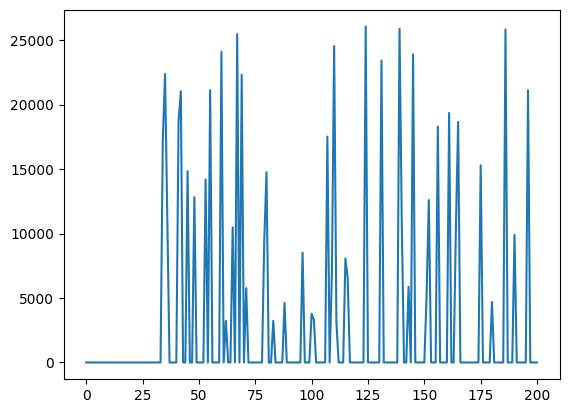

In [262]:
plt.plot(training_IRE_list[-30:] + attack_IRE_list)